In [1]:
from load_data import load_data_singer, load_data_album, load_data_era, plot_tsne
from transformers import AutoTokenizer, AutoModel, pipeline, BertForSequenceClassification
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Era Classification

In [3]:
train_df, test_df = load_data_era()

In [5]:
# load the BERT model for the word embeddings
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
extractor = pipeline("feature-extraction", batch_size=1024, model=model, tokenizer=tokenizer)

In [6]:
def extract_embeddings(train_df, token):
    """Encodes lyrics and for each sentence, returns the vector corresponding to the given token.

    Arguments:
        lyrics (list[str]): The sentences to feed into the model.
        token (str): The token to extract the embedding for.

    Returns:
        A list of vectors, one vector for each input sentence, corresponding to the contextual embedding
        of `token` within `sentence`. (This can be either a PyTorch tensor or a NumPy array.)
    """

    output = []
    for _, row in train_df.iterrows():
        # use the BERT model to translate the sentence (lyric) into a vector
        input_ids = tokenizer(row["lyrics"])["input_ids"]
        token_pos = 0
        # find position of summary token (usually [CLS])
        for i, id in enumerate(input_ids):
            if tokenizer.convert_ids_to_tokens(id) == token.lower():
                token_pos = i

        # append vector of summary token of this lyric to the output
        # we use truncation to handle one song being longer than the maximum number of tokens (743 > 512)
        output.append(extractor(row["lyrics"], return_tensors=True, truncation=True)[0,token_pos,:]) 
    return output

In [7]:
lyric_vectors = extract_embeddings(train_df,"[CLS]")
lyric_vectors_np = [tensor.numpy() for tensor in lyric_vectors] # convert to numpy array to use for scikit_learn algos

Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors


In [8]:
X = lyric_vectors_np
y = train_df["era_id"]

# Define scoring metrics for CV
scoring = ['precision_macro', 'recall_macro', "r2", "accuracy"]


In [9]:
nb_model = make_pipeline(MinMaxScaler(), MultinomialNB())

scores_nb = cross_validate(nb_model, X, y, scoring=scoring)
print("Naive Bayes average CV accuracy:")
np.average(scores_nb["test_accuracy"])


Naive Bayes average CV accuracy:


0.7333333333333333

In [10]:
svm_model = make_pipeline(StandardScaler(), svm.SVC(gamma='auto'))

scores_svm = cross_validate(svm_model, X, y, scoring=scoring)
print("SVM model average CV accuracy:")
np.average(scores_svm["test_accuracy"])

SVM model average CV accuracy:


0.76

In [11]:
tree_model = RandomForestClassifier()

param_grid = {'max_depth': [3, 5, 10],
             'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(tree_model, param_grid)
tree_grid.fit(X, y)
tree_grid.best_params_


{'max_depth': 3, 'min_samples_split': 5}

In [12]:
tree_model = RandomForestClassifier(max_depth=3, min_samples_split=5)

scores_tree = cross_validate(tree_model, X, y, scoring=scoring)
print("Random Forest average CV accuracy:")
print(np.average(scores_tree["test_accuracy"]))

Random Forest average CV accuracy:
0.7733333333333333


In [13]:
logreg_model = LogisticRegression(max_iter=1000)

scores_logreg = cross_validate(logreg_model, X, y, scoring=scoring)
print("Logistic Regression average CV accuracy:")
np.average(scores_logreg["test_accuracy"])



Logistic Regression average CV accuracy:


0.7866666666666666

Logistic Regression shows the best accuracy so we choose this model. Now we test it on the previously withheld test dataset.

In [14]:
lyric_vectors_test = extract_embeddings(test_df,"[CLS]")
lyric_vectors_np_test = [tensor.numpy() for tensor in lyric_vectors_test] 

X_test = lyric_vectors_np_test
y_test = test_df["era_id"]

                precision    recall  f1-score   support

     Tarja Era       0.86      0.67      0.75         9
Post Tarja Era       0.73      0.89      0.80         9

      accuracy                           0.78        18
     macro avg       0.79      0.78      0.77        18
  weighted avg       0.79      0.78      0.77        18



[Text(0, 0, 'Tarja Era'), Text(1, 0, 'Post Tarja Era')]

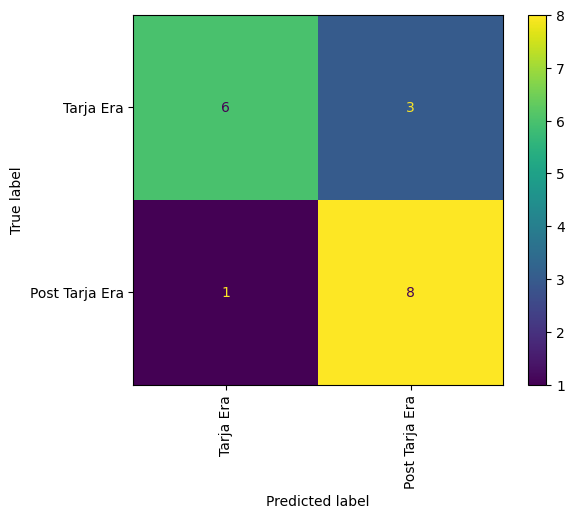

In [15]:
logreg_model = LogisticRegression(max_iter=1000)

# fit model to training data
logreg_model.fit(X,y)
# use the model to predict the test data
logreg_pred = logreg_model.predict(X_test)

### Display the prediction results:

print(classification_report(y_test, logreg_pred, target_names = ["Tarja Era","Post Tarja Era"]))
cm = confusion_matrix(y_test, logreg_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Tarja Era","Post Tarja Era"])
cm_plot.plot()
cm_plot.ax_.set_xticklabels(["Tarja Era","Post Tarja Era"], rotation=90)


# Classification for Singer

In [16]:
train_df2, test_df2 = load_data_singer()

In [17]:
lyric_vectors2 = extract_embeddings(train_df2,"[CLS]")
lyric_vectors_np2 = [tensor.numpy() for tensor in lyric_vectors2] # convert to numpy array to use for scikit_learn algos

In [18]:
X2 = lyric_vectors_np2
y2 = train_df2["singer_id"]

# Define scoring metrics for CV (we add F1 as accuracy is not enough here)
scoring = ['precision_macro', 'recall_macro', "r2", "accuracy", "f1_macro"]

In [19]:
nb_model2 = make_pipeline(MinMaxScaler(), MultinomialNB())

scores_nb2 = cross_validate(nb_model2, X2, y2, scoring=scoring)
print("Naive Bayes average CV accuracy:")
print(np.average(scores_nb2["test_accuracy"]))
print(np.average(scores_nb2["test_f1_macro"]))


Naive Bayes average CV accuracy:
0.7066666666666666
0.6317023327549642


C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
svm_model2 = make_pipeline(StandardScaler(), svm.SVC(gamma='auto'))

scores_svm2 = cross_validate(svm_model2, X2, y2, scoring=scoring)
print("SVM model average CV accuracy:")
print(np.average(scores_svm2["test_accuracy"]))
print(np.average(scores_svm2["test_f1_macro"]))


SVM model average CV accuracy:
0.7066666666666668
0.5525274483970136


C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
tree_model2 = RandomForestClassifier()

param_grid2 = {'max_depth': [3, 5, 10],
             'min_samples_split': [2, 5, 10]}
tree_grid2 = GridSearchCV(tree_model2, param_grid2)
tree_grid2.fit(X2, y2)
tree_grid2.best_params_


{'max_depth': 5, 'min_samples_split': 5}

In [22]:
tree_model2 = RandomForestClassifier(max_depth=5, min_samples_split=5)

scores_tree2= cross_validate(tree_model2, X2, y2, scoring=scoring)
print("Random Forest average CV accuracy:")
print(np.average(scores_tree2["test_accuracy"]))
print(np.average(scores_tree2["test_f1_macro"]))


C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest average CV accuracy:
0.76
0.6401731601731602


C:\Users\nikos\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
logreg_model2 = LogisticRegression(max_iter=1000)

scores_logreg2 = cross_validate(logreg_model2, X2, y2, scoring=scoring)
print("Logistic Regression average CV accuracy:")
print(np.average(scores_logreg2["test_accuracy"]))
print(np.average(scores_logreg2["test_f1_macro"]))


Logistic Regression average CV accuracy:
0.7466666666666667
0.69938662644545


Again Logistic Regression proves to be the best model, so we choose this to use on the test dataset.

In [25]:
lyric_vectors_test = extract_embeddings(test_df2,"[CLS]")
lyric_vectors_np_test = [tensor.numpy() for tensor in lyric_vectors_test] 

X_test = lyric_vectors_np_test
y_test = test_df2["singer_id"]

               precision    recall  f1-score   support

Tarja Turunen       0.60      0.75      0.67         8
 Annika Olzon       0.50      0.40      0.44         5
 Floor Jansen       0.50      0.40      0.44         5

     accuracy                           0.56        18
    macro avg       0.53      0.52      0.52        18
 weighted avg       0.54      0.56      0.54        18



[Text(0, 0, 'Tarja Turunen'),
 Text(1, 0, 'Annika Olzon'),
 Text(2, 0, 'Floor Jansen')]

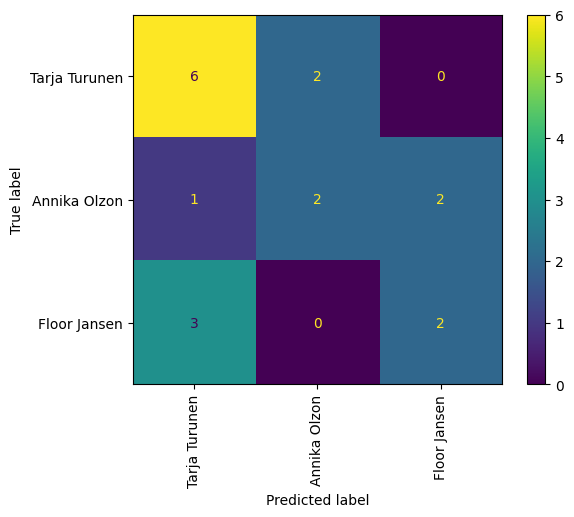

In [26]:
logreg_model = LogisticRegression(max_iter=1000)

# fit model to training data
logreg_model.fit(X2,y2)
logreg_pred = logreg_model.predict(X_test)

### Display the prediction results:

print(classification_report(y_test, logreg_pred, target_names = ["Tarja Turunen","Annika Olzon", "Floor Jansen"]))
cm = confusion_matrix(y_test, logreg_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Tarja Turunen","Annika Olzon", "Floor Jansen"])
cm_plot.plot()
cm_plot.ax_.set_xticklabels(["Tarja Turunen","Annika Olzon", "Floor Jansen"], rotation=90)
